<a href="https://colab.research.google.com/github/deburky/boosting-scorecards/blob/main/other_notebooks/WoeBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **WoeBoost**: Weight of Evidence (WOE) Gradient Boosting
---
Effortlessly build interpretable and high-performing models with **WoeBoost**, a framework that combines the power of gradient boosting with the interpretability of Weight of Evidence (WOE).

⭐ **Repo**: [GitHub Repository](https://github.com/xRiskLab/woeboost)

💡 **Key Features**:
- Transparent, evidence-based machine learning.
- Supports monotonicity constraints for interpretable predictions.
- Easy-to-use API for training and prediction.

---

In [1]:
%pip install woeboost pycaleva --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 937.8/937.8 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.8/227.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 820.8/820.8 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 5.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython==7.34.0, but you have ipython 8.30.0 which is incompatible.


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Fetch blended credit data
url = (
    "https://drive.google.com/file/d/1Is8UZnPRExI-SLJMle8GRbFGpha5IvYZ/view?usp=sharing"
)
url = "https://drive.google.com/uc?id=" + url.split("/")[-2]
dataset = pd.read_csv(url, index_col=False)

features = [
    "revolving_utilization_of_unsecured_lines",
    "account_never_delinq_percent",
    "net_fraction_revolving_burden",
    "external_risk_estimate",
    "num_total_cc_accounts",
    "average_months_in_file",
]

target = 'is_bad'

X, y = dataset[features], dataset[target]

ix_train, ix_test = train_test_split(
    X.index, stratify=y, test_size=0.3, random_state=62
)

## 👩‍💻 Model Training

The model can be fit without any pre-specified hyperparameters.

In [3]:
from woeboost import WoeBoostClassifier
from sklearn.metrics import roc_auc_score

model = WoeBoostClassifier()
model.fit(X.loc[ix_train], y.loc[ix_train])

probas = model.predict_proba(X.loc[ix_test])[:, 1]
gini = 2 * roc_auc_score(y.loc[ix_test], probas) - 1
print(f"Test Gini score: {gini:.2%}")

Test Gini score: 88.43%


## 📏 Calibration

We use `pycaleva` package to plot calibration summary.

100%|██████████| 50/50 [00:02<00:00, 19.42it/s]


calbelt_result(statistic=3.3976532642130906, pvalue=0.18289800484234942, fig=<Figure size 1000x600 with 1 Axes>)

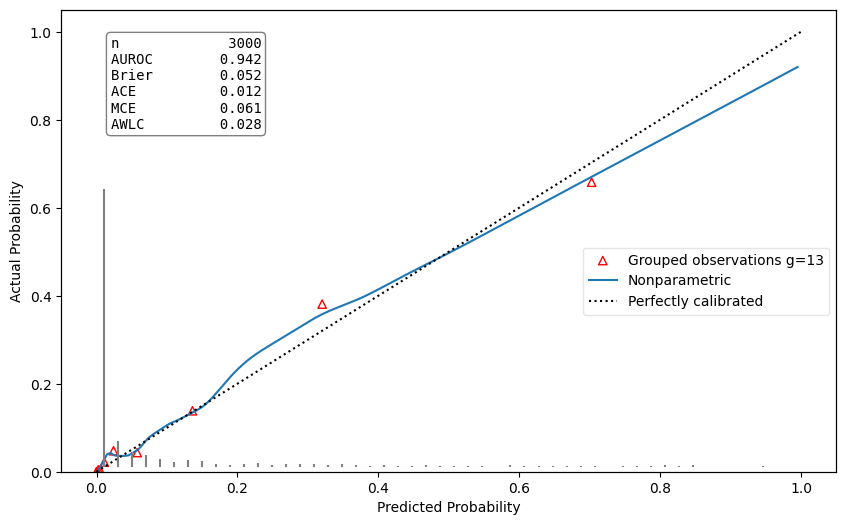

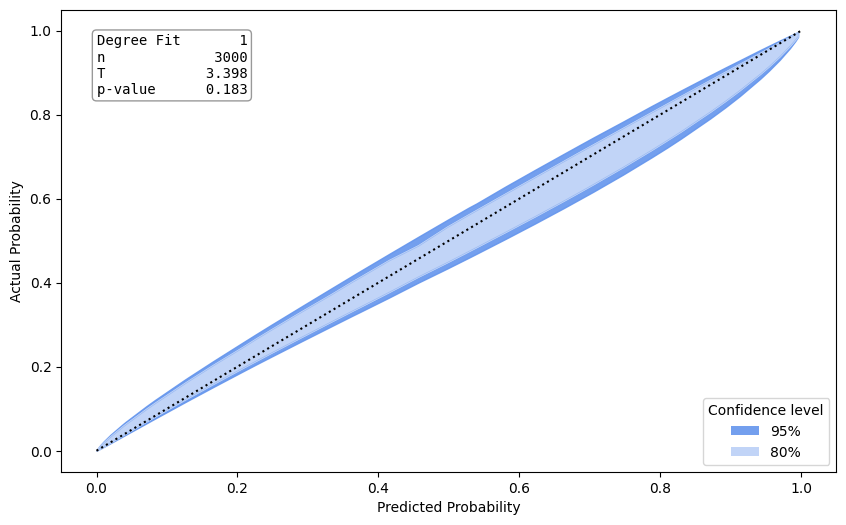

In [4]:
from pycaleva import CalibrationEvaluator
ce = CalibrationEvaluator(y.loc[ix_test], probas, outsample=True, n_groups='auto')
ce.calibration_plot()
ce.calbelt(plot=True)

## 🔍 Feature contributions

We can display a summary of feature contributions to understand their importance.

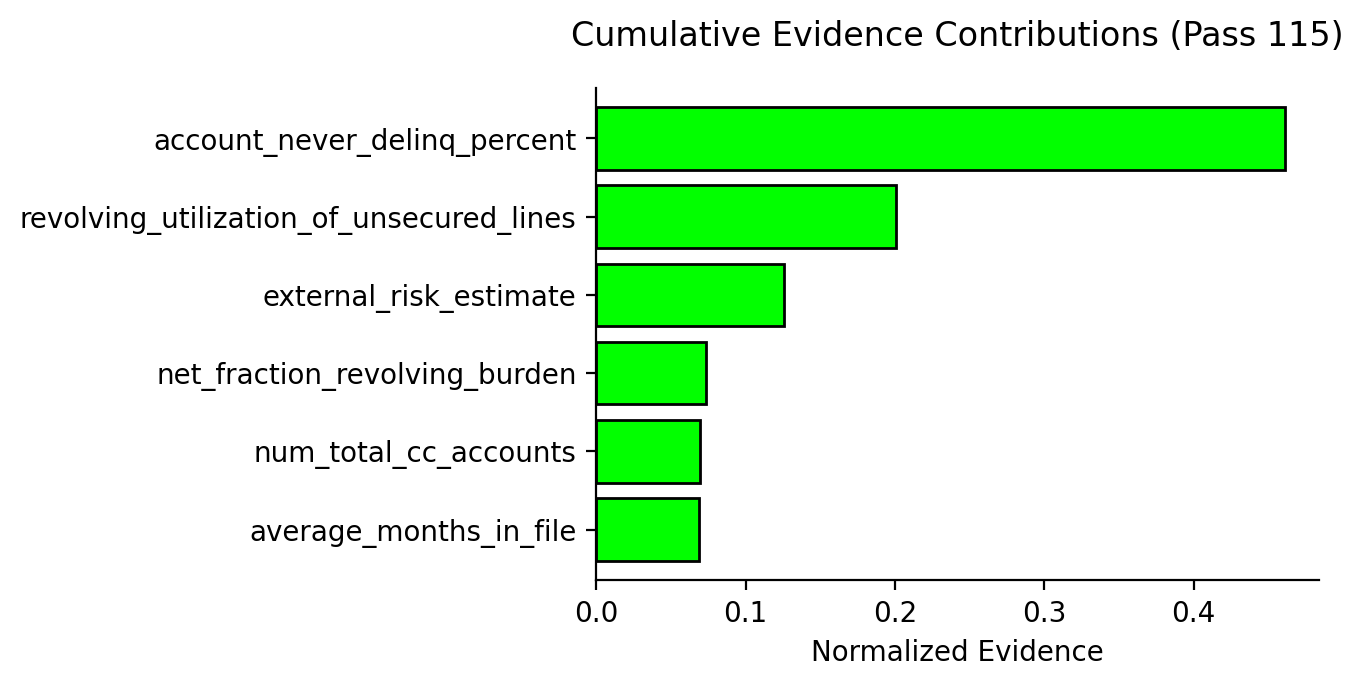

In [18]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from woeboost.explainer import EvidenceAnalyzer

# Generate the plot
analyzer = EvidenceAnalyzer(model=model, df=X.loc[ix_test])
contributions = analyzer.calculate_contributions(mode="cumulative")
analyzer.plot_contributions(contributions, mode="cumulative")
fig = plt.gcf()
fig.set_size_inches(6, 3)
plt.show()

## 🥅 Score distribution

Here we use deciban scores to visualize the distribution of good and bad risk.

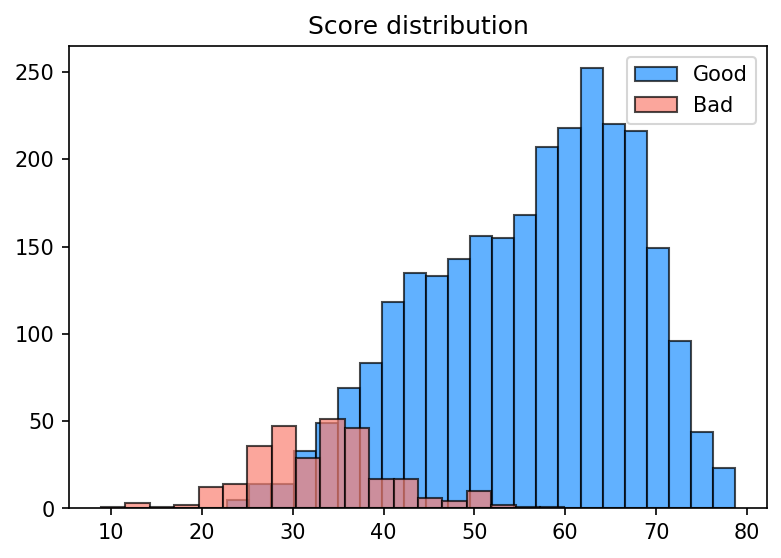

In [20]:
import matplotlib.pyplot as plt

# Create scores
preds = -model.predict_score(X.loc[ix_test]) + 40

fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
pd.Series(preds[y.loc[ix_test] == 0]).hist(edgecolor='black', bins='auto', color='dodgerblue', grid=False, alpha=0.7, ax=ax)
pd.Series(preds[y.loc[ix_test] == 1]).hist(edgecolor='black', bins='auto', color='salmon', grid=False, alpha=0.7, ax=ax)
plt.legend(['Good', 'Bad'])
plt.title('Score distribution')
plt.show()